In [1]:
infile<-"/home/raquel.dias/redcap_nec/OptimalFeedingTubeDw_DATA_LABELS_2023-01-09_1146.csv"
infile_nec<-"/home/raquel.dias/redcap_nec/OptimalFeedingTubeDw-NEC_DATA_2023-01-23_0957.csv"

In [2]:
mydata <- read.csv(infile)
mydata_nec <- read.csv(infile_nec)

In [3]:
mydata_nec$merged <- rowSums(mydata_nec[,3:5], na.rm=TRUE)
ind <- rowSums(is.na(mydata_nec[,3:5])) == ncol(mydata_nec[,3:5])
mydata_nec$merged[ind] <- NA
mydata_nec$merged[mydata_nec$merged>=1] <- 1
mydata_nec_merged <- aggregate(mydata_nec$merged, by = list(mydata_nec$study_id), FUN = function(x) max(x, na.rm = !all(is.na(x))))
names(mydata_nec_merged) <- c("Study.ID", "NEC")                               

In [ ]:
mydata_BPD <- mydata[mydata$Chronic.lung.disease..oxygen.....36.weeks.CGA.!='', c("Study.ID", 'Chronic.lung.disease..oxygen.....36.weeks.CGA.')]

mydata_BPD[,2] <- as.numeric(as.factor(mydata[mydata$Chronic.lung.disease..oxygen.....36.weeks.CGA.!='','Chronic.lung.disease..oxygen.....36.weeks.CGA.' ]))-1
names(mydata_BPD) <- c("Study.ID", "BPD")                               
mydata_BPD

In [5]:
t0_data <- mydata[mydata$Event.Name=="Initial Contact",]
t0_data <- t0_data[-which(t0_data$Birth.weight..grams.==max(t0_data$Birth.weight..grams.)),]
t0_data$Size.of.FT <- as.numeric(gsub(" FR","", t0_data$Size.of.FT))

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


In [6]:
tN_data <- mydata[mydata$Event.Name!="Initial Contact",]
tN_data <- tN_data[!sapply(tN_data, function (x) all(is.na(x) | x == ""))]


In [7]:
num_cols <- unlist(lapply(tN_data[,c(3:ncol(tN_data))], is.numeric))         # Identify numeric columns
tN_data_num <- tN_data[, c("Study.ID",names(num_cols[num_cols==TRUE]))]
#tN_data_num[is.na(tN_data_num)] <- 0

In [8]:
num_cols <- unlist(lapply(t0_data[,c(3:ncol(t0_data))], is.numeric))         # Identify numeric columns
t0_data_num <- t0_data[, c("Study.ID",names(num_cols[num_cols==TRUE]))]
t0_data_chr <- t0_data[, c("Study.ID",names(num_cols[num_cols==FALSE]))]

ncol(t0_data_chr)
uniquelength <- sapply(t0_data_chr,function(x) length(unique(x)))
t0_data_chr <- subset(t0_data_chr, select=uniquelength>1)
                       
ncol(t0_data_chr)
ncol(t0_data_num)

[1] 218

[1] 74

[1] 60

In [9]:
library(caret)

dummy <- dummyVars(" ~ .", data=t0_data_chr)
t0_data_chr_oh <- data.frame(predict(dummy, newdata = t0_data_chr)) 

Loading required package: ggplot2

Loading required package: lattice



In [10]:
t0_data_num_clean <- t0_data_num[ , which(apply(t0_data_num, 2, var) != 0)]
all_data_t0 <- merge(t0_data_num_clean, t0_data_chr_oh, by="Study.ID")
PCA <- prcomp(all_data_t0[,-1], center = TRUE, scale = TRUE, rank = 100)
str(PCA)
ncol(all_data_t0)

List of 5
 $ sdev    : num [1:150] 4.01 3.27 3.19 2.82 2.77 ...
 $ rotation: num [1:330, 1:100] -0.0301 -0.0152 0.0024 -0.0251 -0.0126 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:330] "Maternal.age" "Gravida" "Term" "Pre.term" ...
  .. ..$ : chr [1:100] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:330] 28.28 2.993 0.86 0.473 0.64 ...
  ..- attr(*, "names")= chr [1:330] "Maternal.age" "Gravida" "Term" "Pre.term" ...
 $ scale   : Named num [1:330] 5.983 2.269 1.253 0.825 1.233 ...
  ..- attr(*, "names")= chr [1:330] "Maternal.age" "Gravida" "Term" "Pre.term" ...
 $ x       : num [1:150, 1:100] 1.172 -1.274 -1.388 0.941 -1.393 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:100] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


[1] 331

In [11]:
# Activate the R packages
correlationMatrix <- cor(all_data_t0[,-1])
# summarize the correlation matrix
#print(correlationMatrix)
# find attributes that are highly corrected (ideally >0.75)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.5)
# print indexes of highly correlated attributes
print(highlyCorrelated)

  [1]   6  30  31  39  51  52  61  68  80  81  83  88  89  94  95  98  99 110
 [19] 111 269 270 271 273 274 276 278 279 282 287 288 291 293 294 295 297 299
 [37] 300 302 303 305 308 309 310 312 314 315 317 318 320 321 323 324 328 329
 [55] 330   2   8  10  13  14  16  18  20  22  24  26  28  32  34  36  43  46
 [73]  47  48  55  58  60  64  70  73  74  75  86  90  92  96 100 102 104 106
 [91] 108 112 114  72 116 118 120 122  79  45  50  76  11 119  85  44  54  62
[109]  59   5  53 261 263 165   7 266 265 268 283 284 285 289 143 177 145 322


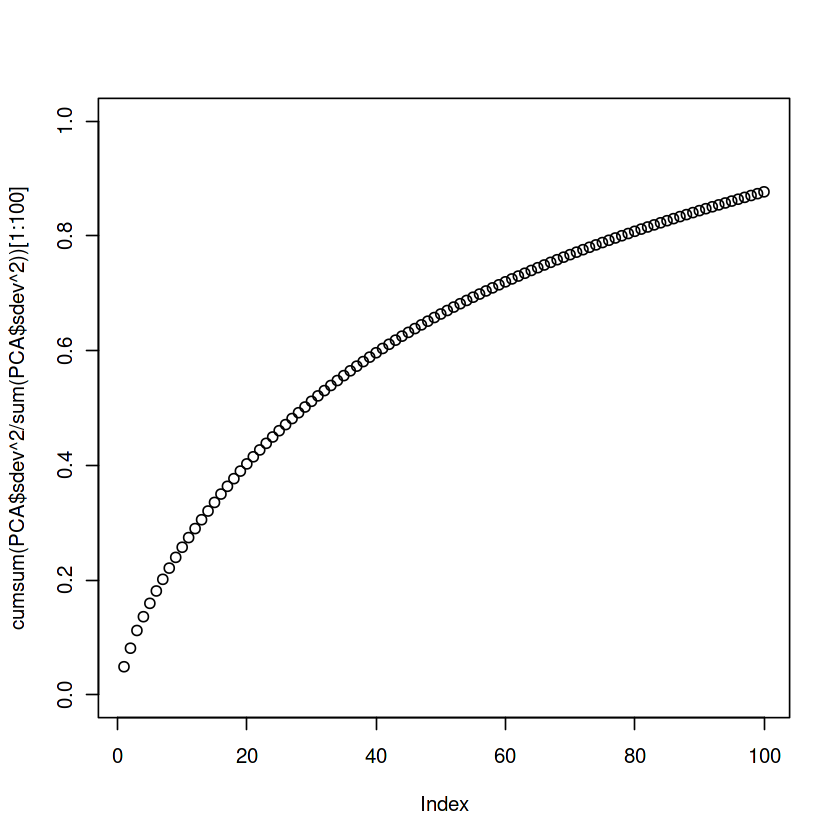

In [12]:
variance_explained <- PCA$sd^2/sum(PCA$sd^2)*100 
plot(cumsum(PCA$sdev^2 / sum(PCA$sdev^2))[1:100], type="b", ylim=0:1)

In [13]:
variance_explained

[1] 4.870835e+00 3.232027e+00 3.091182e+00 2.403550e+00 2.331969e+00
  [6] 2.155257e+00 2.032936e+00 1.956134e+00 1.873212e+00 1.766455e+00
 [11] 1.682788e+00 1.570148e+00 1.545571e+00 1.517900e+00 1.501171e+00
 [16] 1.456749e+00 1.352357e+00 1.335093e+00 1.319148e+00 1.257711e+00
 [21] 1.237319e+00 1.195163e+00 1.151818e+00 1.107543e+00 1.096611e+00
 [26] 1.061608e+00 1.058422e+00 1.014912e+00 9.963948e-01 9.938583e-01
 [31] 9.465948e-01 9.213950e-01 8.935840e-01 8.629851e-01 8.551411e-01
 [36] 8.395968e-01 8.124299e-01 7.959469e-01 7.796076e-01 7.627189e-01
 [41] 7.448497e-01 7.339933e-01 7.177352e-01 6.972788e-01 6.640058e-01
 [46] 6.576647e-01 6.489107e-01 6.448471e-01 6.344037e-01 6.142413e-01
 [51] 6.106655e-01 6.003208e-01 5.826252e-01 5.722599e-01 5.657017e-01
 [56] 5.469268e-01 5.428175e-01 5.381514e-01 5.344157e-01 5.205267e-01
 [61] 5.037564e-01 5.010144e-01 4.907397e-01 4.876566e-01 4.783376e-01
 [66] 4.741771e-01 4.635178e-01 4.552627e-01 4.472780e-01 4.371026e-01
 [71] 4.349248e-01 4.305066e-01 4.200327e-01 4.163459e-01 4.073380e-01
 [76] 3.989365e-01 3.968617e-01 3.917169e-01 3.886686e-01 3.858743e-01
 [81] 3.821144e-01 3.708273e-01 3.677475e-01 3.653998e-01 3.626988e-01
 [86] 3.593707e-01 3.557472e-01 3.498232e-01 3.481151e-01 3.434221e-01
 [91] 3.385669e-01 3.342617e-01 3.313596e-01 3.302154e-01 3.294092e-01
 [96] 3.266954e-01 3.242197e-01 3.235120e-01 3.214096e-01 3.193373e-01
[101] 3.184030e-01 3.136743e-01 3.133542e-01 3.127915e-01 3.111196e-01
[106] 3.089919e-01 3.077971e-01 3.069701e-01 3.065319e-01 3.058602e-01
[111] 3.056607e-01 3.055807e-01 3.054478e-01 3.053630e-01 3.052236e-01
[116] 3.051538e-01 3.050641e-01 3.050641e-01 3.050641e-01 3.050641e-01
[121] 3.050641e-01 3.050641e-01 3.050641e-01 3.050641e-01 3.050641e-01
[126] 3.050641e-01 3.050641e-01 3.050641e-01 3.050641e-01 3.050641e-01
[131] 3.050641e-01 3.050641e-01 3.050641e-01 3.050641e-01 3.050641e-01
[136] 3.050641e-01 1.765782e-01 1.606590e-01 1.505358e-01 1.349005e-01
[141] 1.205846e-01 1.171166e-01 8.981656e-02 7.801461e-02 6.923929e-02
[146] 6.249615e-02 5.924926e-02 2.719785e-02 1.192125e-02 1.511054e-30

Warning message:
"Removed 110 rows containing missing values (geom_point)."
Warning message:
"Removed 110 row(s) containing missing values (geom_path)."


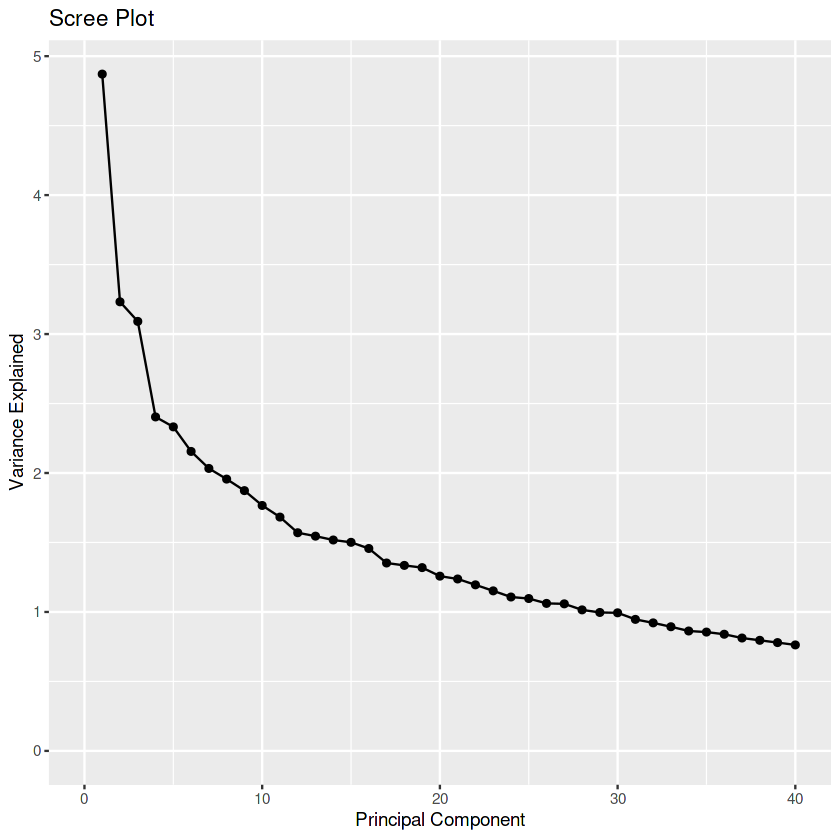

In [14]:
library(caret)
require(graphics)
qplot(c(1:length(variance_explained)), variance_explained) + 
  geom_line() + 
  xlab("Principal Component") + 
  ylab("Variance Explained") +
  ggtitle("Scree Plot") +
xlim(0,40)

[1] "proportions of variance:"
  [1] 4.870835e-02 3.232027e-02 3.091182e-02 2.403550e-02 2.331969e-02
  [6] 2.155257e-02 2.032936e-02 1.956134e-02 1.873212e-02 1.766455e-02
 [11] 1.682788e-02 1.570148e-02 1.545571e-02 1.517900e-02 1.501171e-02
 [16] 1.456749e-02 1.352357e-02 1.335093e-02 1.319148e-02 1.257711e-02
 [21] 1.237319e-02 1.195163e-02 1.151818e-02 1.107543e-02 1.096611e-02
 [26] 1.061608e-02 1.058422e-02 1.014912e-02 9.963948e-03 9.938583e-03
 [31] 9.465948e-03 9.213950e-03 8.935840e-03 8.629851e-03 8.551411e-03
 [36] 8.395968e-03 8.124299e-03 7.959469e-03 7.796076e-03 7.627189e-03
 [41] 7.448497e-03 7.339933e-03 7.177352e-03 6.972788e-03 6.640058e-03
 [46] 6.576647e-03 6.489107e-03 6.448471e-03 6.344037e-03 6.142413e-03
 [51] 6.106655e-03 6.003208e-03 5.826252e-03 5.722599e-03 5.657017e-03
 [56] 5.469268e-03 5.428175e-03 5.381514e-03 5.344157e-03 5.205267e-03
 [61] 5.037564e-03 5.010144e-03 4.907397e-03 4.876566e-03 4.783376e-03
 [66] 4.741771e-03 4.635178e-03 4.552627e-03 4

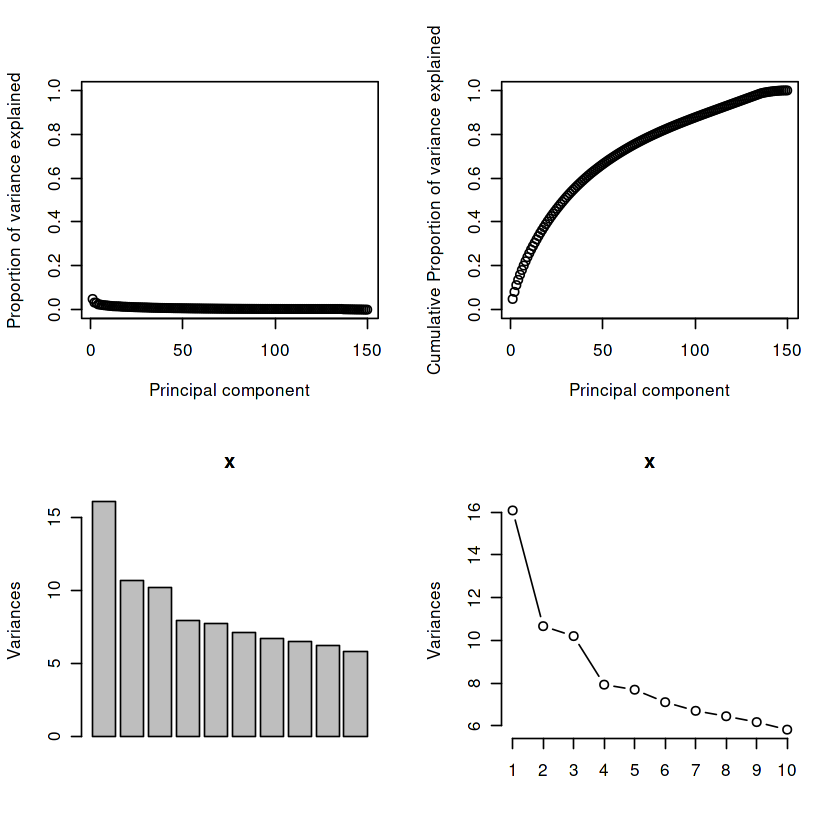

In [15]:
pcaCharts <- function(x) {
    x.var <- x$sdev ^ 2
    x.pvar <- x.var/sum(x.var)
    print("proportions of variance:")
    print(x.pvar)
    
    par(mfrow=c(2,2))
    plot(x.pvar,xlab="Principal component", ylab="Proportion of variance explained", ylim=c(0,1), type='b')
    plot(cumsum(x.pvar),xlab="Principal component", ylab="Cumulative Proportion of variance explained", ylim=c(0,1), type='b')
    screeplot(x)
    screeplot(x,type="l")
    par(mfrow=c(1,1))
}
pcaCharts(PCA)

In [16]:
library(ggpubr)
library(factoextra)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [17]:
res.km <- kmeans(scale(all_data_t0[, -1]), 4, nstart = 25)


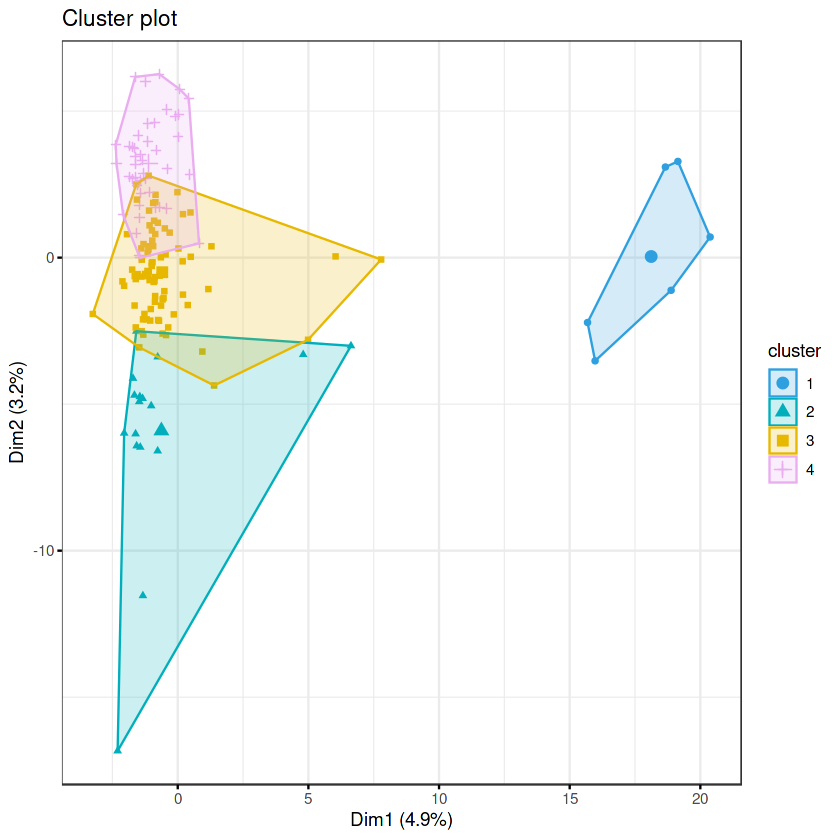

In [18]:
fviz_cluster(res.km, data = all_data_t0[, -1],
             palette = c("#2E9FDF", "#00AFBB", "#E7B800", "#eaadf0", "#f0adb0"), 
             geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             )

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,...,Dim.143,Dim.144,Dim.145,Dim.146,Dim.147,Dim.148,Dim.149,Dim.150,cluster,sample_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,1.1717962,-1.0734214,1.4025334,-2.2415581,0.2019991,-0.6000044,2.813925,-0.9993821,1.0289829,-0.9271419,...,0.29368058,-0.067320656,0.13270615,-0.018124407,0.15638891,-0.013830098,0.056911448,4.996004e-16,3,1
2,-1.2741767,-1.9215205,0.9510590,-2.4895203,-3.4524324,-4.3020748,1.606948,-2.3933740,2.5038626,-2.6801302,...,0.15453104,-0.003957076,-0.02056693,0.141707698,-0.06328942,-0.049244573,0.016925347,2.109424e-15,3,2
3,-1.3877780,-0.6469656,1.1374548,0.3568033,-2.0078484,1.7294401,2.677781,-2.0912881,0.9726055,-0.2188544,...,-0.26884975,0.199328308,-0.03564034,0.002464073,-0.12521603,0.026268035,-0.014116455,-1.998401e-15,3,3
4,0.9408933,-3.2045471,3.4151069,-5.4208738,-2.9085722,0.1934085,6.164729,-2.1665113,-2.7245519,1.0581585,...,0.25973965,-0.120447598,0.10486143,-0.072005521,0.33566566,-0.023907951,0.024947710,1.276756e-15,3,4
5,-1.3929990,0.3153625,0.8302548,-4.0905889,-0.2312156,-5.8774178,2.688065,0.7178755,0.0388408,6.4962470,...,-0.11778120,0.145374260,0.09067795,-0.039280052,-0.04183911,0.030911444,0.034557751,4.385381e-15,3,5
6,-2.3008263,-16.8333164,-5.1093703,14.4176797,-1.1444676,-14.1536555,-1.664216,-2.1219806,-8.3151722,11.3200538,...,0.05654842,0.032488675,0.05451166,0.007745193,-0.02184927,-0.004841862,-0.002914857,-2.220446e-15,2,6


,eigenvalue,variance.percent,cumulative.variance.percent
,<dbl>,<dbl>,<dbl>
Dim.1,16.1,4.9,4.9
Dim.2,10.7,3.2,8.1
Dim.3,10.2,3.1,11.2
Dim.4,7.9,2.4,13.6
Dim.5,7.7,2.3,15.9
Dim.6,7.1,2.2,18.1


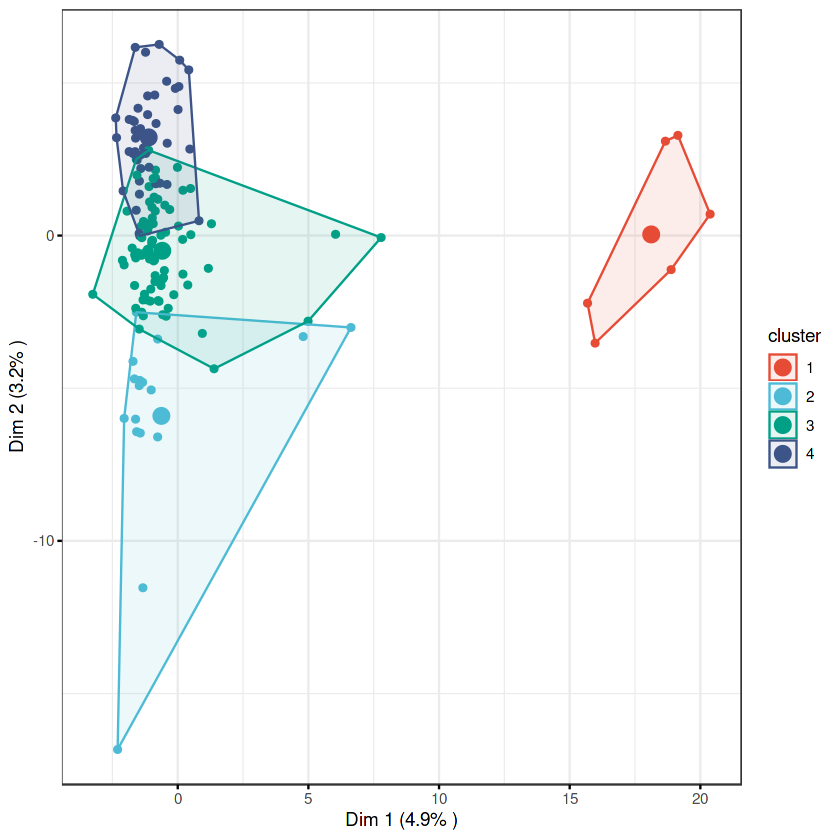

In [19]:

# Dimension reduction using PCA
res.pca <- prcomp(all_data_t0[, -1],  scale = TRUE)
# Coordinates of individuals
ind.coord <- as.data.frame(get_pca_ind(res.pca)$coord)
# Add clusters obtained using the K-means algorithm
ind.coord$cluster <- factor(res.km$cluster)
ind.coord$sample_id <- all_data_t0[, 1]
# Add sample group from the original data sett
#ind.coord$sample_id <- t0_data_num_clean$NEC
# Data inspection
head(ind.coord)

# Percentage of variance explained by dimensions
eigenvalue <- round(get_eigenvalue(res.pca), 1)
variance.percent <- eigenvalue$variance.percent
head(eigenvalue)
ggscatter(
  ind.coord, x = "Dim.1", y = "Dim.2", 
  color = "cluster", palette = "npg", ellipse = TRUE, ellipse.type = "convex",
  #shape = "sample group", 
    size = 1.5,  legend = "right", ggtheme = theme_bw(),
  xlab = paste0("Dim 1 (", variance.percent[1], "% )" ),
  ylab = paste0("Dim 2 (", variance.percent[2], "% )" )
) +
  stat_mean(aes(color = cluster), size = 4)

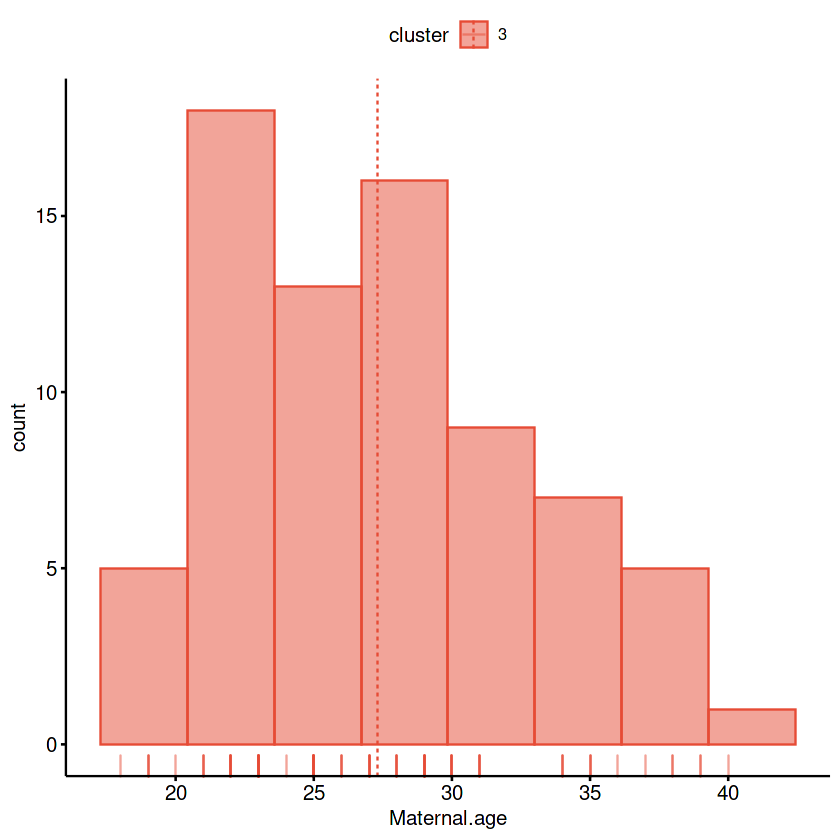

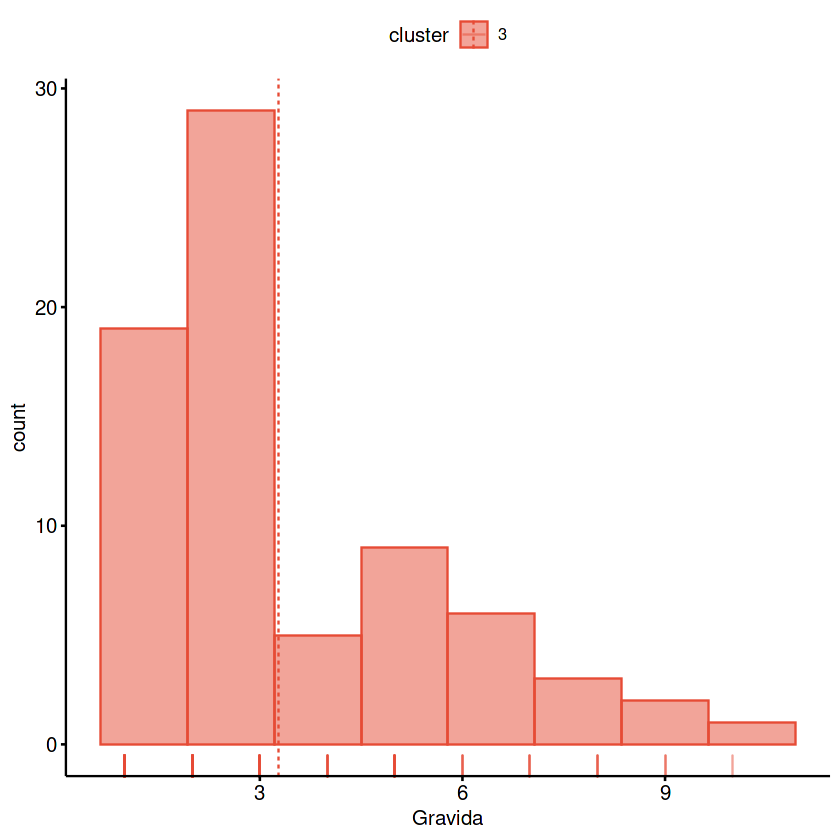

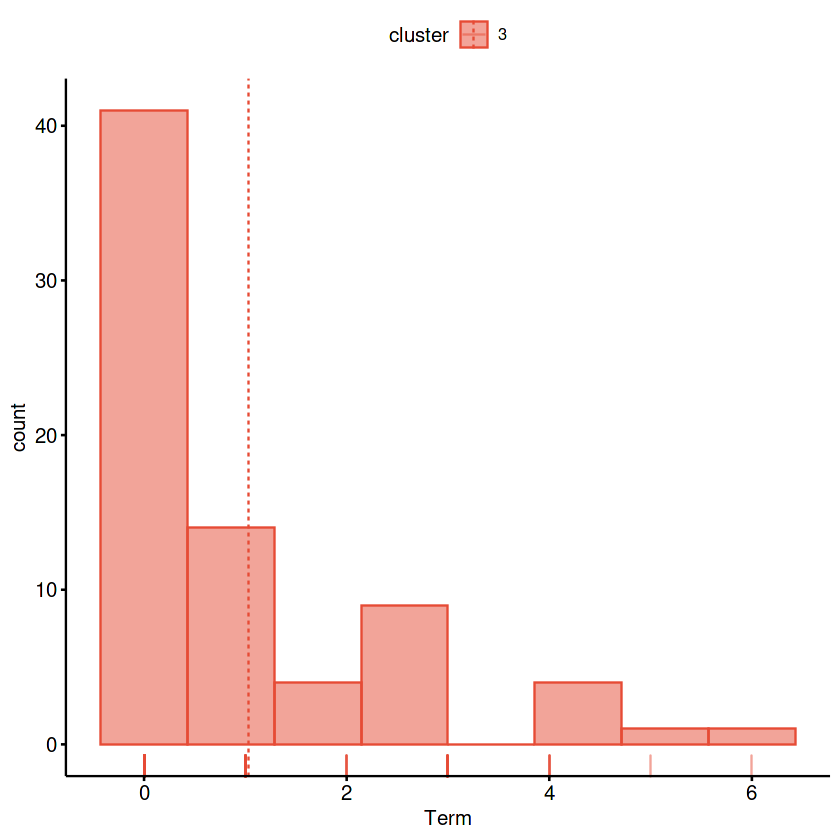

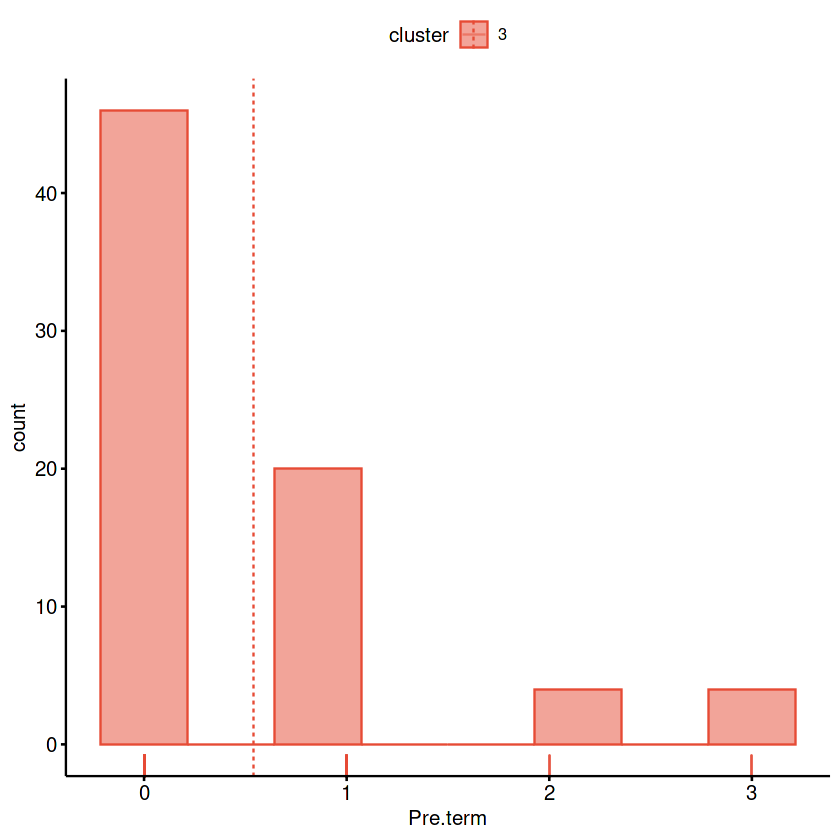

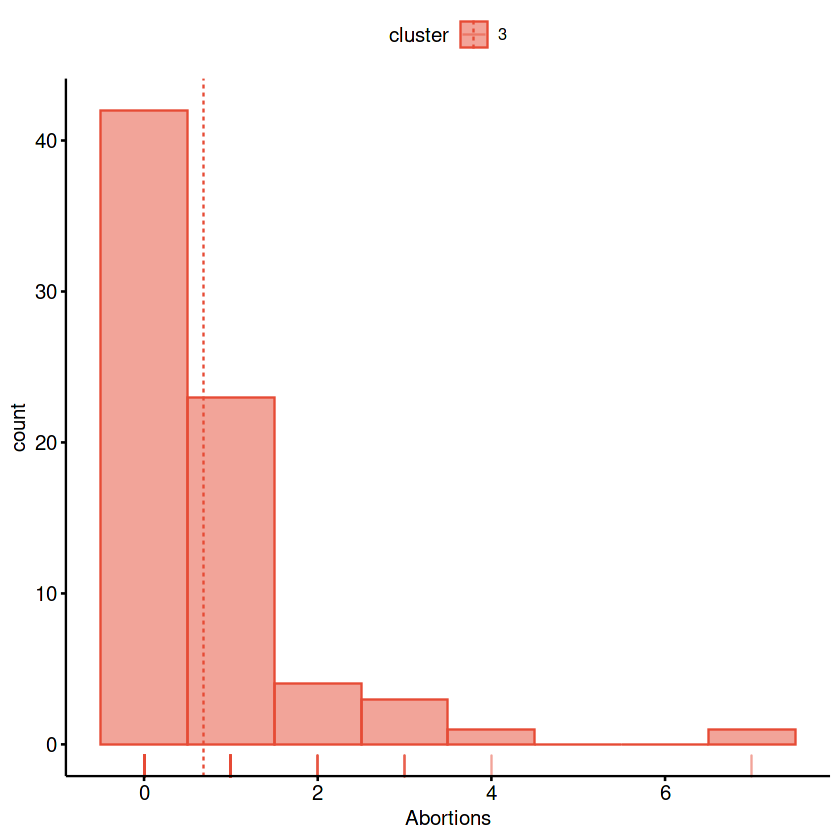

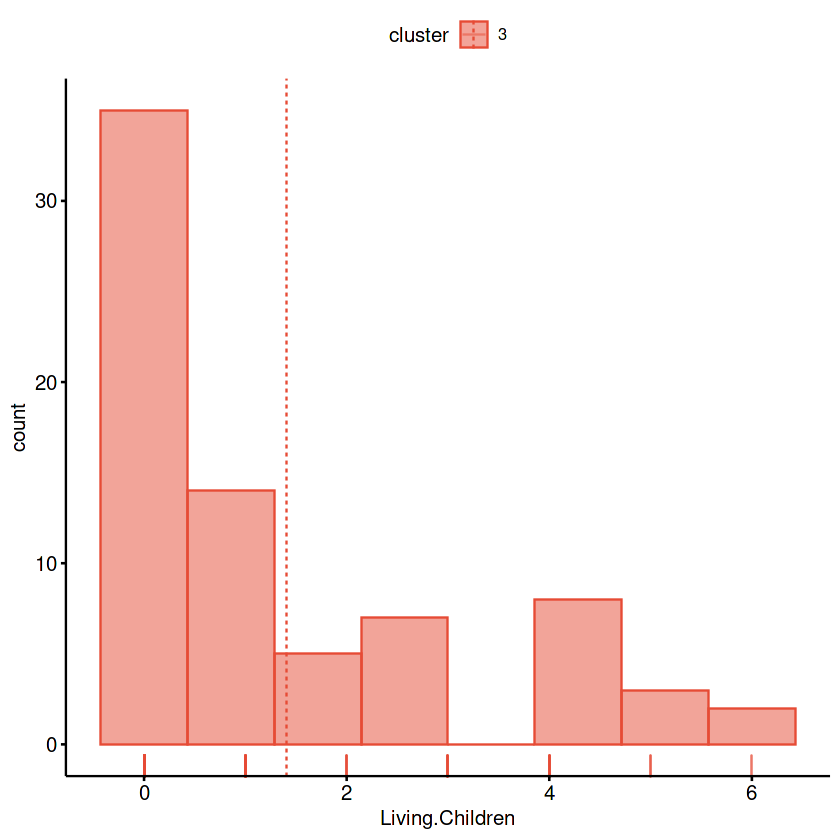

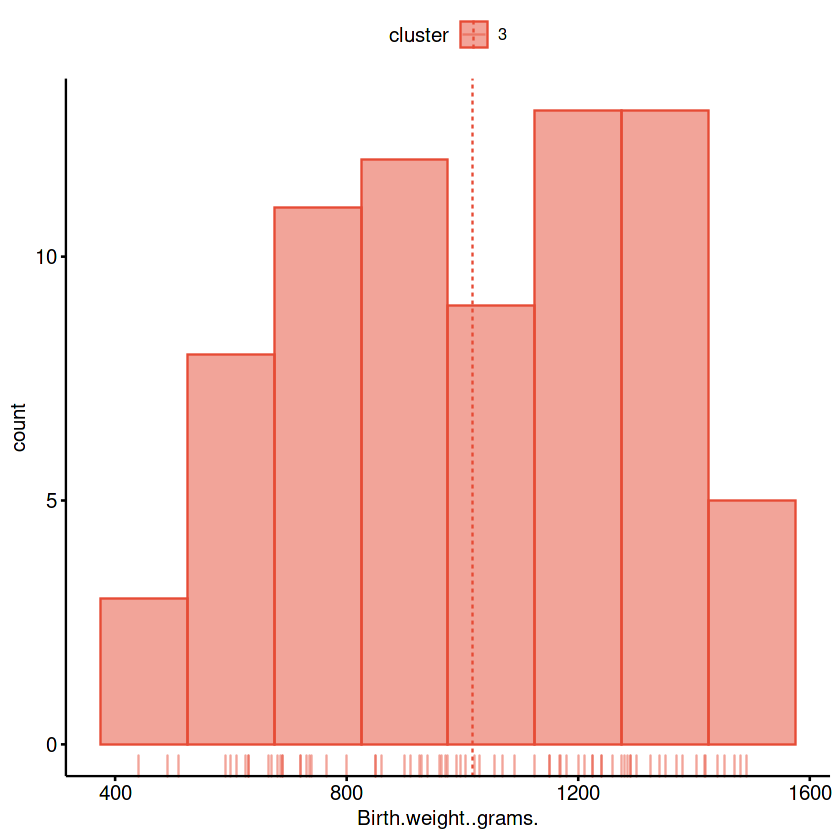

In [20]:
clusters_all <- merge(ind.coord, t0_data_num_clean, by.x = "sample_id", by.y = "Study.ID")
clusters_all <- merge(clusters_all, mydata_nec_merged, by.x = "sample_id", by.y = "Study.ID")
clusters_all <- merge(clusters_all, mydata_BPD, by.x = "sample_id", by.y = "Study.ID")
clusters <- subset(clusters_all, cluster==1 | cluster==3)

#clusters <- subset(clusters, cluster == "1" | cluster == "3" | cluster == "4")
for(i in names(t0_data_num_clean[,-1])){
g <- gghistogram(clusters, x = i,
   add = "mean", rug = TRUE,
   color = "cluster", fill = "cluster",
   palette = "npg", bins = 8)
plot(g)   
}




Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.
Warning message in prop.test(x = c(6, 3), n = c(78, 16)):
"Chi-squared approximation may be incorrect"
Warning message in prop.test(x = c(6, 5), n = c(78, 44)):
"Chi-squared approximation may be incorrect"
Warning message in prop.test(x = c(5, 3), n = c(44, 16)):
"Chi-squared approximation may be incorrect"


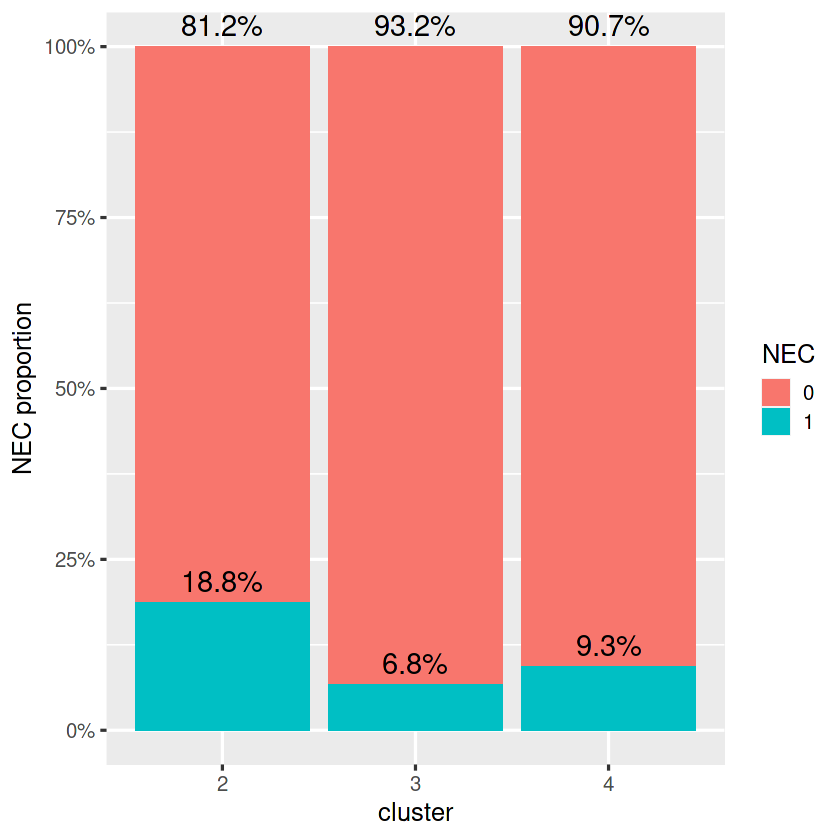

In [21]:
library(dplyr)



for(i in c("NEC", names(t0_data_chr_oh[,-1]))){
    
 clusters_all$x <- clusters_all[,i]
data_to_plot <- clusters_all %>% group_by(cluster, x) %>%
    summarise(non_na_count = sum(!is.na(x))) %>%
    mutate(pct = non_na_count / sum(non_na_count))
data_to_plot <- data_to_plot[complete.cases(data_to_plot),]
    
g <- data_to_plot %>% 
    ggplot(aes(x = cluster, y = pct, fill = factor(x), label = scales::percent(pct))) + 
    geom_col(position = 'stack') + 
    geom_text(position = 'stack',    # move to center of bars
              vjust = -0.5,    # nudge above top of bar
              size = 6) + 
    scale_y_continuous(labels = scales::percent) + labs(y = paste0(i, " proportion")) +
    guides(fill=guide_legend(title=i)) +
    theme(axis.text.x=element_text(size=15)) +
    theme(axis.text.y=element_text(size=15)) +
    theme(legend.text=element_text(size=15)) + 
    theme_grey(base_size = 15)

    
 plot(g)   
 break
}

res1 <- prop.test(x = c(6, 3), n = c(78, 16))
res2 <- prop.test(x = c(6, 5), n = c(78, 44))
res3 <- prop.test(x = c(5, 3), n = c(44, 16))


`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.


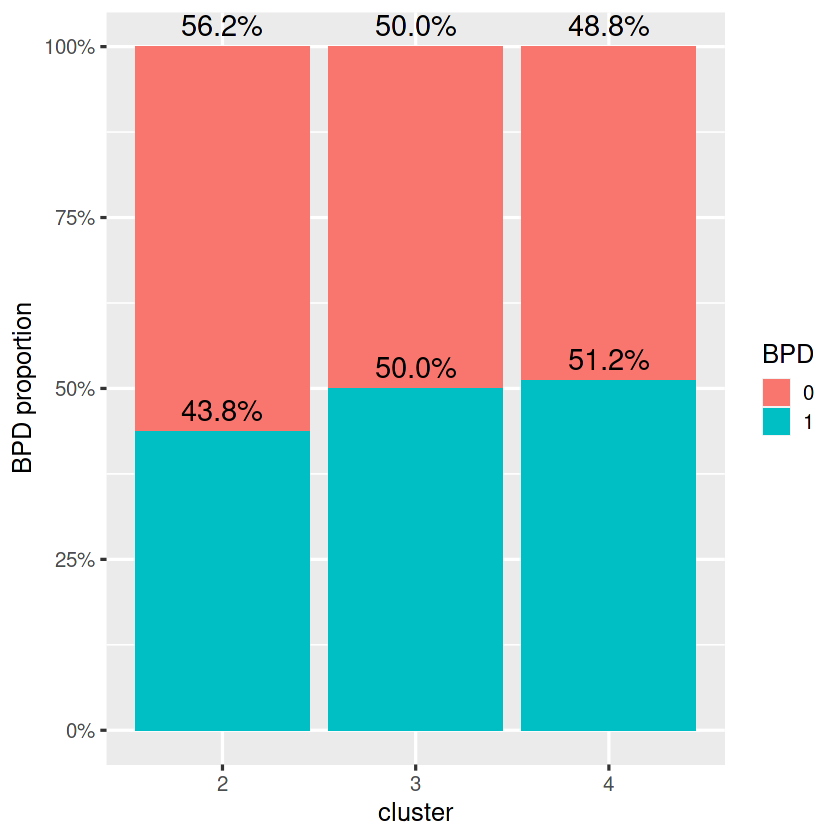

In [22]:
library(dplyr)



for(i in c("BPD", names(t0_data_chr_oh[,-1]))){
    
 clusters_all$x <- clusters_all[,i]
data_to_plot <- clusters_all %>% group_by(cluster, x) %>%
    summarise(non_na_count = sum(!is.na(x))) %>%
    mutate(pct = non_na_count / sum(non_na_count))
data_to_plot <- data_to_plot[complete.cases(data_to_plot),]
    
g <- data_to_plot %>% 
    ggplot(aes(x = cluster, y = pct, fill = factor(x), label = scales::percent(pct))) + 
    geom_col(position = 'stack') + 
    geom_text(position = 'stack',    # move to center of bars
              vjust = -0.5,    # nudge above top of bar
              size = 6) + 
    scale_y_continuous(labels = scales::percent) + labs(y = paste0(i, " proportion")) +
    guides(fill=guide_legend(title=i)) +
    theme(axis.text.x=element_text(size=15)) +
    theme(axis.text.y=element_text(size=15)) +
    theme(legend.text=element_text(size=15)) + 
    theme_grey(base_size = 15)

    
 plot(g)   
 break
}

res1 <- prop.test(x = c(37, 22), n = c(74, 43))
res2 <- prop.test(x = c(37, 7), n = c(74, 16))
res3 <- prop.test(x = c(22, 7), n = c(43, 16))


In [24]:
data_to_plot

cluster,x,non_na_count,pct
<fct>,<dbl>,<int>,<dbl>
2,0,9,0.5625000
2,1,7,0.4375000
3,0,37,0.5000000
3,1,37,0.5000000
4,0,21,0.4883721
4,1,22,0.5116279


In [23]:
names(t0_data_chr_oh[,-1])

[1] "Group.to.which.the.subject.has.been.randomizedChange.FT.every.0.48h" 
  [2] "Group.to.which.the.subject.has.been.randomizedChange.FT.every.7.days"
  [3] "RaceAfrican.American"                                                
  [4] "RaceAsian"                                                           
  [5] "RaceCaucasian"                                                       
  [6] "RaceOther"                                                           
  [7] "Ethnicity.1..Hispanic..Latino"                                       
  [8] "Ethnicity.2..Non.Hispanic..Latino"                                   
  [9] "Maternal.history..choice.PIH.Checked"                                
 [10] "Maternal.history..choice.PIH.Unchecked"                              
 [11] "Maternal.history..choice.Chronic.HTN.Checked"                        
 [12] "Maternal.history..choice.Chronic.HTN.Unchecked"                      
 [13] "Maternal.history..choice.Diabetes.Checked"                           
 [14] "Maternal.history..choice.Diabetes.Unchecked"                         
 [15] "Maternal.history..choice.Illicit.drug.use.Checked"                   
 [16] "Maternal.history..choice.Illicit.drug.use.Unchecked"                 
 [17] "Maternal.history..choice.Obesity.Checked"                            
 [18] "Maternal.history..choice.Obesity.Unchecked"                          
 [19] "Maternal.history..choice.GDM.Checked"                                
 [20] "Maternal.history..choice.GDM.Unchecked"                              
 [21] "Maternal.history..choice.HELLP.Checked"                              
 [22] "Maternal.history..choice.HELLP.Unchecked"                            
 [23] "Maternal.history..choice.Pre.Eclampsia.Checked"                      
 [24] "Maternal.history..choice.Pre.Eclampsia.Unchecked"                    
 [25] "Maternal.history..choice.Smoker.Checked"                             
 [26] "Maternal.history..choice.Smoker.Unchecked"                           
 [27] "Maternal.history..choice.Other.Checked"                              
 [28] "Maternal.history..choice.Other.Unchecked"                            
 [29] "GBS.Negative"                                                        
 [30] "GBS.Positive"                                                        
 [31] "GBS.Unknown"                                                         
 [32] "Adequate.GBS.prophylaxis...4.hoursN.A"                               
 [33] "Adequate.GBS.prophylaxis...4.hoursNo"                                
 [34] "Adequate.GBS.prophylaxis...4.hoursUnknown"                           
 [35] "Adequate.GBS.prophylaxis...4.hoursYes"                               
 [36] "RPR.VDRL..Syphilis.Negative"                                         
 [37] "RPR.VDRL..Syphilis.Positive"                                         
 [38] "RPR.VDRL..Syphilis.Unknown"                                          
 [39] "HbsAgNegative"                                                       
 [40] "HbsAgPositive"                                                       
 [41] "HbsAgUnknown"                                                        
 [42] "Hep.C.AntibodyNegative"                                              
 [43] "Hep.C.AntibodyPositive"                                              
 [44] "Hep.C.AntibodyUnknown"                                               
 [45] "HIVNegative"                                                         
 [46] "HIVPositive"                                                         
 [47] "HIVUnknown"                                                          
 [48] "Rubella.Immune"                                                      
 [49] "Rubella.Non.Immune"                                                  
 [50] "Rubella.Unknown"                                                     
 [51] "ChlamydiaNegative"                                                   
 [52] "ChlamydiaPositive"                                                  

In [349]:
res1
res2
res3


	2-sample test for equality of proportions with continuity correction

data:  c(37, 22) out of c(74, 43)
X-squared = 5.2396e-31, df = 1, p-value = 1
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.2111385  0.1878826
sample estimates:
   prop 1    prop 2 
0.5000000 0.5116279 



	2-sample test for equality of proportions with continuity correction

data:  c(37, 7) out of c(74, 16)
X-squared = 0.031585, df = 1, p-value = 0.8589
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.243952  0.368952
sample estimates:
prop 1 prop 2 
0.5000 0.4375 



	2-sample test for equality of proportions with continuity correction

data:  c(22, 7) out of c(43, 16)
X-squared = 0.045564, df = 1, p-value = 0.831
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.2540690  0.4023248
sample estimates:
   prop 1    prop 2 
0.5116279 0.4375000 


In [25]:
data_to_plot <- clusters_all %>% group_by(cluster, NEC) %>%
    summarise(non_na_count = sum(!is.na(NEC))) %>%
    mutate(pct = non_na_count / sum(non_na_count))
data_to_plot <- data_to_plot[complete.cases(data_to_plot),]
data_to_plot

`summarise()` has grouped output by 'cluster'. You can override using the
`.groups` argument.


cluster,NEC,non_na_count,pct
<fct>,<dbl>,<int>,<dbl>
2,0,13,0.81250000
2,1,3,0.18750000
3,0,69,0.93243243
3,1,5,0.06756757
4,0,39,0.90697674
4,1,4,0.09302326


In [26]:
count(factor(clusters_all$NEC))

ERROR: Error in UseMethod("count"): no applicable method for 'count' applied to an object of class "factor"


In [27]:
table(clusters_all[,c("cluster","NEC")])

       NEC
cluster  0  1
      1  0  0
      2 13  3
      3 69  5
      4 39  4

In [28]:
table(clusters_all[,c("cluster","BPD")])

       BPD
cluster  0  1
      1  0  0
      2  9  7
      3 37 37
      4 21 22

In [29]:
data_to_plot

cluster,NEC,non_na_count,pct
<fct>,<dbl>,<int>,<dbl>
2,0,13,0.81250000
2,1,3,0.18750000
3,0,69,0.93243243
3,1,5,0.06756757
4,0,39,0.90697674
4,1,4,0.09302326


In [30]:
library(pheatmap)
library(RColorBrewer)
library(viridis)

Loading required package: viridisLite



In [31]:
annot <- data.frame(cluster=clusters_all$cluster)
row.names(annot) <- clusters_all$sample_id
summary(clusters_all$cluster)

1  2  3  4 
 0 16 74 43

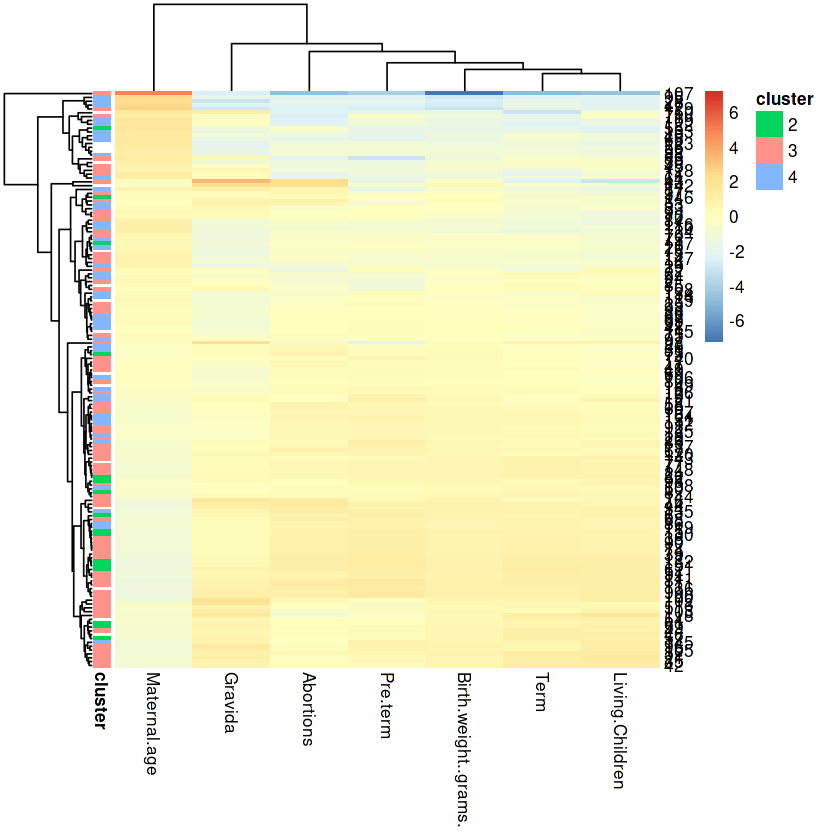

In [32]:
cal_z_score <- function(x){
(x - mean(x)) / sd(x)
}
data_subset_norm <- t(apply(t0_data_num_clean[,-1], 1, cal_z_score))
row.names(data_subset_norm) <- t0_data_num_clean[,1]
pheatmap(data_subset_norm, center=TRUE, scale='column', annotation_row = annot)

In [33]:
names(clusters_all)

[1] "sample_id"            "Dim.1"                "Dim.2"               
  [4] "Dim.3"                "Dim.4"                "Dim.5"               
  [7] "Dim.6"                "Dim.7"                "Dim.8"               
 [10] "Dim.9"                "Dim.10"               "Dim.11"              
 [13] "Dim.12"               "Dim.13"               "Dim.14"              
 [16] "Dim.15"               "Dim.16"               "Dim.17"              
 [19] "Dim.18"               "Dim.19"               "Dim.20"              
 [22] "Dim.21"               "Dim.22"               "Dim.23"              
 [25] "Dim.24"               "Dim.25"               "Dim.26"              
 [28] "Dim.27"               "Dim.28"               "Dim.29"              
 [31] "Dim.30"               "Dim.31"               "Dim.32"              
 [34] "Dim.33"               "Dim.34"               "Dim.35"              
 [37] "Dim.36"               "Dim.37"               "Dim.38"              
 [40] "Dim.39"               "Dim.40"               "Dim.41"              
 [43] "Dim.42"               "Dim.43"               "Dim.44"              
 [46] "Dim.45"               "Dim.46"               "Dim.47"              
 [49] "Dim.48"               "Dim.49"               "Dim.50"              
 [52] "Dim.51"               "Dim.52"               "Dim.53"              
 [55] "Dim.54"               "Dim.55"               "Dim.56"              
 [58] "Dim.57"               "Dim.58"               "Dim.59"              
 [61] "Dim.60"               "Dim.61"               "Dim.62"              
 [64] "Dim.63"               "Dim.64"               "Dim.65"              
 [67] "Dim.66"               "Dim.67"               "Dim.68"              
 [70] "Dim.69"               "Dim.70"               "Dim.71"              
 [73] "Dim.72"               "Dim.73"               "Dim.74"              
 [76] "Dim.75"               "Dim.76"               "Dim.77"              
 [79] "Dim.78"               "Dim.79"               "Dim.80"              
 [82] "Dim.81"               "Dim.82"               "Dim.83"              
 [85] "Dim.84"               "Dim.85"               "Dim.86"              
 [88] "Dim.87"               "Dim.88"               "Dim.89"              
 [91] "Dim.90"               "Dim.91"               "Dim.92"              
 [94] "Dim.93"               "Dim.94"               "Dim.95"              
 [97] "Dim.96"               "Dim.97"               "Dim.98"              
[100] "Dim.99"               "Dim.100"              "Dim.101"             
[103] "Dim.102"              "Dim.103"              "Dim.104"             
[106] "Dim.105"              "Dim.106"              "Dim.107"             
[109] "Dim.108"              "Dim.109"              "Dim.110"             
[112] "Dim.111"              "Dim.112"              "Dim.113"             
[115] "Dim.114"              "Dim.115"              "Dim.116"             
[118] "Dim.117"              "Dim.118"              "Dim.119"             
[121] "Dim.120"              "Dim.121"              "Dim.122"             
[124] "Dim.123"              "Dim.124"              "Dim.125"             
[127] "Dim.126"              "Dim.127"              "Dim.128"             
[130] "Dim.129"              "Dim.130"              "Dim.131"             
[133] "Dim.132"              "Dim.133"              "Dim.134"             
[136] "Dim.135"              "Dim.136"              "Dim.137"             
[139] "Dim.138"              "Dim.139"              "Dim.140"             
[142] "Dim.141"              "Dim.142"              "Dim.143"             
[145] "Dim.144"              "Dim.145"              "Dim.146"             
[148] "Dim.147"              "Dim.148"              "Dim.149"             
[151] "Dim.150"              "cluster"              "Maternal.age"        
[154] "Gravida"              "Term"                 "Pre.term"            
[157] "Abortions"            "Living.Children"      "Birth.weight..grams."
[160] "NEC"                

In [ ]:
library(RColorBrewer)
id_order <- rbind(
    subset(clusters_all, cluster==1),
    subset(clusters_all, cluster==2),
    subset(clusters_all, cluster==3),
    subset(clusters_all, cluster==4)
)

annot <- data.frame(sample_id=id_order$sample_id, cluster=id_order$cluster)

#annot <- annot[id_order,]

data_to_plot <- t0_data_num_clean
#data_to_plot <- data_to_plot[complete.cases(data_to_plot),]

data_to_plot <- merge(data_to_plot, annot, by.x="Study.ID", by.y="sample_id")


data_to_plot <- data_to_plot[order(data_to_plot$cluster),] 
annot <- annot[order(data_to_plot$cluster),] 
#data_to_plot <- data_to_plot[id_order$sample_id,]
head(data_to_plot)
head(annot)

row.names(data_to_plot) <- data_to_plot[,"Study.ID"]
row.names(annot) <- id_order$sample_id

data_to_plot$Study.ID <- NULL

data_to_plot$cluster <- NULL
annot$sample_id <- NULL
str(data_to_plot)
#nrow(t0_data_num_clean)
nrow(annot)
nrow(data_to_plot)
pheatmap(data_to_plot, center=TRUE, scale='column', color = brewer.pal(n = 5, name = "RdBu"),
         annotation_row = annot, cluster_rows = FALSE)

In [38]:
length(complete.cases(all_data_t0))

[1] 150

In [ ]:
library(RColorBrewer)
id_order <- rbind(
    subset(clusters_all, cluster==1),
    subset(clusters_all, cluster==2),
    subset(clusters_all, cluster==3),
    subset(clusters_all, cluster==4)
)

annot <- data.frame(sample_id=id_order$sample_id, cluster=id_order$cluster)

#annot <- annot[id_order,]
#names(all_data_t0)
data_to_plot <- all_data_t0
#data_to_plot <- data_to_plot[complete.cases(data_to_plot),]

data_to_plot <- merge(data_to_plot, annot, by.x="Study.ID", by.y="sample_id")


data_to_plot <- data_to_plot[order(data_to_plot$cluster),] 
annot <- annot[order(data_to_plot$cluster),] 
#data_to_plot <- data_to_plot[id_order$sample_id,]
head(data_to_plot)
head(annot)

row.names(data_to_plot) <- data_to_plot[,"Study.ID"]
row.names(annot) <- id_order$sample_id

data_to_plot$Study.ID <- NULL

data_to_plot$cluster <- NULL
annot$sample_id <- NULL
#str(data_to_plot)
nrow(annot)
nrow(data_to_plot)
data_to_plot <- data_to_plot[,c(8:ncol(data_to_plot))]

pheatmap(data_to_plot, center=TRUE, scale='column', brewer.pal(n = 5, name = "RdBu"),
          cellheight = 1, cellwidth = 3,
         annotation_row = annot, cluster_rows = FALSE, cluster_cols = FALSE)

In [58]:
#2=1
mean(subset(clusters_all, cluster==2)$Maternal.age)
#4=3
mean(subset(clusters_all, cluster==4)$Maternal.age)

[1] 25.625

[1] 30.67442

In [59]:
#2=1
sd(subset(clusters_all, cluster==2)$Maternal.age)
#4=3
sd(subset(clusters_all, cluster==4)$Maternal.age)

[1] 5.737305

[1] 6.457631

In [60]:
#2=1
mean(subset(clusters_all, cluster==2)$Birth.weight..grams.)
#4=3
mean(subset(clusters_all, cluster==4)$Birth.weight..grams.)

[1] 1064.312

[1] 911

In [61]:
#2=1
sd(subset(clusters_all, cluster==2)$Birth.weight..grams.)
#4=3
sd(subset(clusters_all, cluster==4)$Birth.weight..grams.)

[1] 257.5025

[1] 239.8652